In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers, models

img_size = (224, 224)
batch = 32
# Loading the data
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Brain Tumor/train",
    image_size=img_size,
    batch_size=batch,
    label_mode="categorical"
)

ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Brain Tumor/valid",
    image_size=img_size,
    batch_size=batch,
    label_mode="categorical"
)
# 1. understanding the data
class_names = ds_train.class_names
print("Classes:", class_names)

# 2. Data PreProcessing
normalization = layers.Rescaling(1.0/255.0)

# 3. Data augmentation & normalization
augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

ds_train = ds_train.map(lambda x, y: (augmentation(normalization(x)), y))
ds_val   = ds_val.map(lambda x, y: (normalization(x), y))

Found 1695 files belonging to 4 classes.
Found 502 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


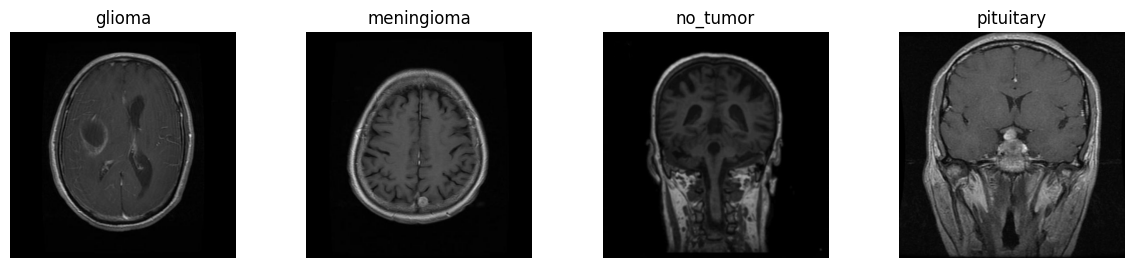

In [7]:
import os
import matplotlib.pyplot as plt
import cv2
import random
# Sample images per class
plt.figure(figsize=(12, 10))
train_path = "/content/drive/MyDrive/Brain Tumor/train"
i = 1
for cls in class_names:
    class_folder = os.path.join(train_path, cls)
    sample_images = os.listdir(class_folder)
    random_img = random.choice(sample_images)
    img = plt.imread(os.path.join(class_folder, random_img))

    plt.subplot(len(class_names), 4, i)
    plt.imshow(img, cmap="gray")
    plt.title(cls)
    plt.axis("off")
    i += 1

plt.tight_layout()
plt.show()

Image Count Per Class: {'glioma': 564, 'meningioma': 358, 'no_tumor': 335, 'pituitary': 438}


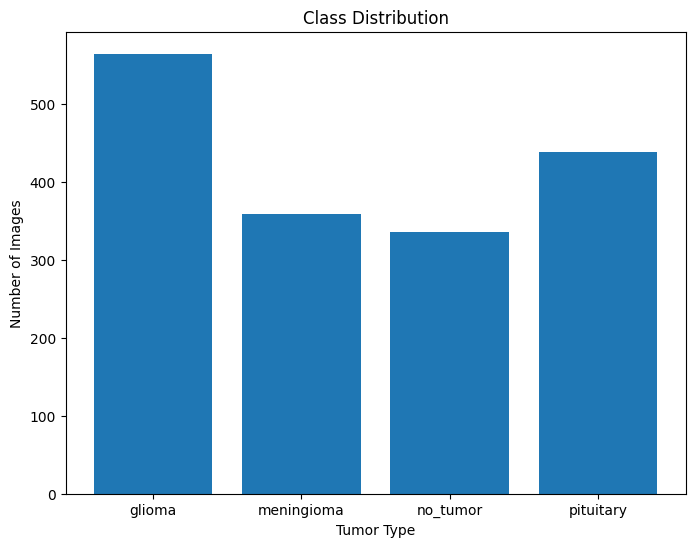

In [9]:
# Check Class Imbalance
from collections import Counter

img_counts = {}
resolutions = []

for cls in class_names:
    folder = os.path.join(train_path, cls)
    files = os.listdir(folder)

    img_counts[cls] = len(files)

    for f in files[:50]:  # Sample 50 images per class for resolution check
        img = cv2.imread(os.path.join(folder, f))
        if img is not None:
            resolutions.append(img.shape[:2])  # (height, width)

print("Image Count Per Class:", img_counts)

# Plot class imbalance
plt.figure(figsize=(8, 6))
plt.bar(img_counts.keys(), img_counts.values())
plt.title("Class Distribution")
plt.xlabel("Tumor Type")
plt.ylabel("Number of Images")
plt.show()



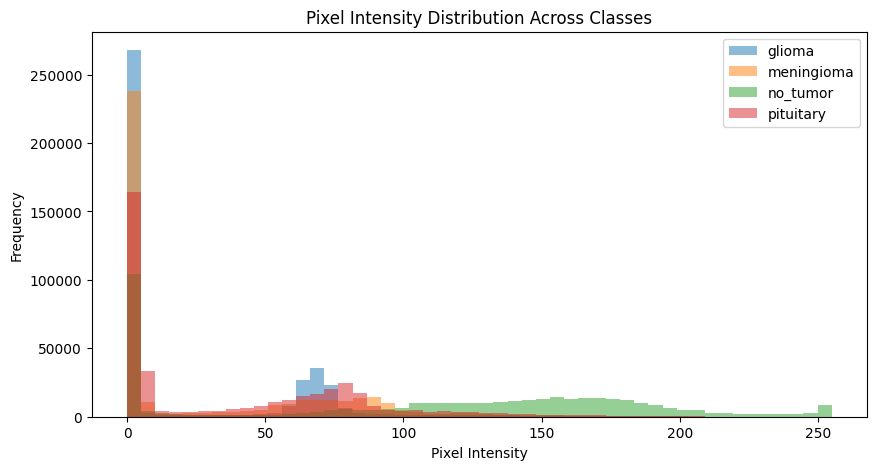

In [10]:
# Explore Image Pixel Intensity Distributions Visually
import numpy as np

plt.figure(figsize=(10, 5))

for cls in class_names:
    folder = os.path.join(train_path, cls)
    sample_file = random.choice(os.listdir(folder))
    img = plt.imread(os.path.join(folder, sample_file))

    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    plt.hist(img.flatten(), bins=50, alpha=0.5, label=cls)

plt.title("Pixel Intensity Distribution Across Classes")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [ ]:
#4.  Custom Residual CNN
def residual_block(x, filters):
    shortcut = x

    x = layers.Conv2D(filters, 3, padding="same", activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, padding="same", activation=None)(x)
    x = layers.BatchNormalization()(x)

    # Match shortcut shape
    shortcut = layers.Conv2D(filters, 1, padding="same")(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

# Deep CNN
inputs = layers.Input(shape=(224, 224, 3))

x = layers.Conv2D(32, 5, padding="same", activation="relu")(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

x = residual_block(x, 64)
x = layers.MaxPooling2D()(x)

x = residual_block(x, 128)
x = layers.MaxPooling2D()(x)

x = residual_block(x, 256)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(256, 3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.4)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = models.Model(inputs, outputs)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 224, 224,  │      2,432 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 112, 112,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 112, 112,  │      2,112 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 56, 56,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 56, 56,    │    147,584 │ re_lu_2[0][0]   

 Total params: 1,803,844 (6.88 MB)

 Trainable params: 1,801,476 (6.87 MB)

 Non-trainable params: 2,368 (9.25 KB)

In [ ]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train with Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "/content/drive/MyDrive/Brain Tumor/best_custom_cnn.h5",
        save_best_only=True
    )
]

# 6. Model Training
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.6146 - loss: 0.9273

53/53 ━━━━━━━━━━━━━━━━━━━━ 74s 971ms/step - accuracy: 0.6157 - loss: 0.9253 - val_accuracy: 0.3207 - val_loss: 1.6350
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 549ms/step - accuracy: 0.7493 - loss: 0.7007 - val_accuracy: 0.3207 - val_loss: 2.1449
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 545ms/step - accuracy: 0.7713 - loss: 0.6182 - val_accuracy: 0.3207 - val_loss: 2.4554
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 547ms/step - accuracy: 0.7966 - loss: 0.5694 - val_accuracy: 0.3367 - val_loss: 2.1297
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8244 - loss: 0.4786

53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 576ms/step - accuracy: 0.8243 - loss: 0.4790 - val_accuracy: 0.4622 - val_loss: 1.5778
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.8058 - loss: 0.4887

53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 580ms/step - accuracy: 0.8060 - loss: 0.4883 - val_accuracy: 0.4641 - val_loss: 1.3966
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 567ms/step - accuracy: 0.8284 - loss: 0.4291 - val_accuracy: 0.3785 - val_loss: 2.1886
Epoch 8/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.8487 - loss: 0.4256

53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 583ms/step - accuracy: 0.8487 - loss: 0.4255 - val_accuracy: 0.4900 - val_loss: 1.2348
Epoch 9/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.8549 - loss: 0.3823

53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 584ms/step - accuracy: 0.8549 - loss: 0.3824 - val_accuracy: 0.6016 - val_loss: 1.0174
Epoch 10/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.8389 - loss: 0.4128

53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 590ms/step - accuracy: 0.8391 - loss: 0.4127 - val_accuracy: 0.7729 - val_loss: 0.7072
Epoch 11/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 553ms/step - accuracy: 0.8641 - loss: 0.3599 - val_accuracy: 0.6892 - val_loss: 0.8030
Epoch 12/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.8828 - loss: 0.3271

53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 583ms/step - accuracy: 0.8828 - loss: 0.3274 - val_accuracy: 0.7231 - val_loss: 0.6757
Epoch 13/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.8663 - loss: 0.3522

53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 592ms/step - accuracy: 0.8666 - loss: 0.3517 - val_accuracy: 0.7888 - val_loss: 0.6323
Epoch 14/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 556ms/step - accuracy: 0.8777 - loss: 0.3405 - val_accuracy: 0.5916 - val_loss: 1.0310
Epoch 15/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 543ms/step - accuracy: 0.8876 - loss: 0.3055 - val_accuracy: 0.7151 - val_loss: 0.8631
Epoch 16/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 545ms/step - accuracy: 0.8942 - loss: 0.3007 - val_accuracy: 0.7171 - val_loss: 0.7985
Epoch 17/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.8931 - loss: 0.2942

53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 615ms/step - accuracy: 0.8931 - loss: 0.2942 - val_accuracy: 0.7809 - val_loss: 0.5663
Epoch 18/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.9021 - loss: 0.2596

53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 658ms/step - accuracy: 0.9020 - loss: 0.2597 - val_accuracy: 0.8426 - val_loss: 0.4544
Epoch 19/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 564ms/step - accuracy: 0.9096 - loss: 0.2415 - val_accuracy: 0.6394 - val_loss: 1.2011
Epoch 20/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 551ms/step - accuracy: 0.9118 - loss: 0.2284 - val_accuracy: 0.5837 - val_loss: 1.5511
Epoch 21/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 543ms/step - accuracy: 0.9147 - loss: 0.2528 - val_accuracy: 0.7052 - val_loss: 1.1549
Epoch 22/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.9141 - loss: 0.2495

53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 576ms/step - accuracy: 0.9142 - loss: 0.2492 - val_accuracy: 0.8705 - val_loss: 0.3525
Epoch 23/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 564ms/step - accuracy: 0.9231 - loss: 0.2328 - val_accuracy: 0.7430 - val_loss: 0.7659
Epoch 24/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 548ms/step - accuracy: 0.9245 - loss: 0.2182 - val_accuracy: 0.7550 - val_loss: 0.7212
Epoch 25/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 545ms/step - accuracy: 0.9171 - loss: 0.2372 - val_accuracy: 0.6554 - val_loss: 1.1772
Epoch 26/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.9266 - loss: 0.2155

53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 581ms/step - accuracy: 0.9267 - loss: 0.2153 - val_accuracy: 0.9124 - val_loss: 0.3031
Epoch 27/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 559ms/step - accuracy: 0.9190 - loss: 0.2011 - val_accuracy: 0.7988 - val_loss: 0.4879
Epoch 28/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 549ms/step - accuracy: 0.9386 - loss: 0.1687 - val_accuracy: 0.7271 - val_loss: 0.9434
Epoch 29/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 548ms/step - accuracy: 0.9261 - loss: 0.2079 - val_accuracy: 0.6016 - val_loss: 1.5748
Epoch 30/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 555ms/step - accuracy: 0.9313 - loss: 0.1844 - val_accuracy: 0.8108 - val_loss: 0.5208


In [ ]:
# 5. Transfer Learning - EfficientNetB0
img_size = (224, 224)
batch = 32
AUTOTUNE = tf.data.AUTOTUNE

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Brain Tumor/train",
    image_size=img_size,
    batch_size=batch,
    label_mode="categorical"
)

ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Brain Tumor/valid",
    image_size=img_size,
    batch_size=batch,
    label_mode="categorical"
)

# Prefetch
ds_train = ds_train.prefetch(AUTOTUNE)
ds_val = ds_val.prefetch(AUTOTUNE)


# Data Preprocessing

from tensorflow.keras.applications.efficientnet import preprocess_input

augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

ds_train = ds_train.map(lambda x, y: (preprocess_input(augmentation(x)), y))
ds_val   = ds_val.map(lambda x, y: (preprocess_input(x), y))


# Transfer Learning - training only top layers

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

base_model.trainable = False   # Freeze

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.3)(x)
output = layers.Dense(4, activation="softmax")(x)

eff_model = models.Model(inputs=base_model.input, outputs=output)

# Compile Transfer model
eff_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "/content/drive/MyDrive/Brain Tumor/best_effnet_stage1.h5",
        save_best_only=True
    )
]

history1 = eff_model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=20,
    callbacks=callbacks
)


# Fine Tune
for layer in base_model.layers[-20:]:
    layer.trainable = True

eff_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks_ft = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "/content/drive/MyDrive/Brain Tumor/best_effnet_finetuned.h5",
        save_best_only=True
    )
]

history2 = eff_model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=20,
    callbacks=callbacks_ft
)


Found 1695 files belonging to 4 classes.
Found 502 files belonging to 4 classes.
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.5183 - loss: 1.1456

53/53 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.5203 - loss: 1.1417 - val_accuracy: 0.7271 - val_loss: 0.7332
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.7432 - loss: 0.6784

53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 504ms/step - accuracy: 0.7437 - loss: 0.6776 - val_accuracy: 0.7570 - val_loss: 0.6131
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.7815 - loss: 0.5870

53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 501ms/step - accuracy: 0.7817 - loss: 0.5865 - val_accuracy: 0.7749 - val_loss: 0.5590
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.8053 - loss: 0.5145

53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 496ms/step - accuracy: 0.8056 - loss: 0.5141 - val_accuracy: 0.7729 - val_loss: 0.5521
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8393 - loss: 0.4875

53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 506ms/step - accuracy: 0.8392 - loss: 0.4871 - val_accuracy: 0.8028 - val_loss: 0.5132
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 26s 484ms/step - accuracy: 0.8323 - loss: 0.4672 - val_accuracy: 0.7689 - val_loss: 0.5423
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.8401 - loss: 0.4464

53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 500ms/step - accuracy: 0.8402 - loss: 0.4459 - val_accuracy: 0.8147 - val_loss: 0.4773
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 475ms/step - accuracy: 0.8502 - loss: 0.4278 - val_accuracy: 0.7968 - val_loss: 0.4909
Epoch 9/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 472ms/step - accuracy: 0.8551 - loss: 0.4138 - val_accuracy: 0.7849 - val_loss: 0.5003
Epoch 10/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 476ms/step - accuracy: 0.8661 - loss: 0.3797 - val_accuracy: 0.8147 - val_loss: 0.4782
Epoch 11/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.8475 - loss: 0.3909

53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 496ms/step - accuracy: 0.8476 - loss: 0.3907 - val_accuracy: 0.8406 - val_loss: 0.4411
Epoch 12/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 516ms/step - accuracy: 0.8530 - loss: 0.3958 - val_accuracy: 0.7789 - val_loss: 0.5117
Epoch 13/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 473ms/step - accuracy: 0.8602 - loss: 0.3782 - val_accuracy: 0.7988 - val_loss: 0.4882
Epoch 14/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 473ms/step - accuracy: 0.8620 - loss: 0.3860 - val_accuracy: 0.8207 - val_loss: 0.4492
Epoch 15/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.8638 - loss: 0.3682

53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 505ms/step - accuracy: 0.8641 - loss: 0.3678 - val_accuracy: 0.8287 - val_loss: 0.4372
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.7391 - loss: 0.6616

53/53 ━━━━━━━━━━━━━━━━━━━━ 77s 960ms/step - accuracy: 0.7395 - loss: 0.6611 - val_accuracy: 0.8347 - val_loss: 0.4339
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 26s 476ms/step - accuracy: 0.7977 - loss: 0.5514 - val_accuracy: 0.8327 - val_loss: 0.4410
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 464ms/step - accuracy: 0.8401 - loss: 0.4909 - val_accuracy: 0.8267 - val_loss: 0.4478
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 461ms/step - accuracy: 0.8419 - loss: 0.4568 - val_accuracy: 0.8307 - val_loss: 0.4542
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 26s 484ms/step - accuracy: 0.8421 - loss: 0.4269 - val_accuracy: 0.8367 - val_loss: 0.4528
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 26s 473ms/step - accuracy: 0.8443 - loss: 0.4297 - val_accuracy: 0.8287 - val_loss: 0.4484


In [ ]:
class_names = ds_train_raw.class_names


In [ ]:
# 7. Model Evaluation
# Evaluation Metrics (Accuracy, Precision, Recall, F1-score)
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = []
y_pred = []

for images, labels in ds_val:
    preds = eff_model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:

              precision    recall  f1-score   support

      glioma       0.91      0.91      0.91       161
  meningioma       0.83      0.57      0.68       124
    no_tumor       0.84      0.86      0.85        99
   pituitary       0.76      0.99      0.86       118

    accuracy                           0.83       502
   macro avg       0.83      0.83      0.82       502
weighted avg       0.84      0.83      0.83       502



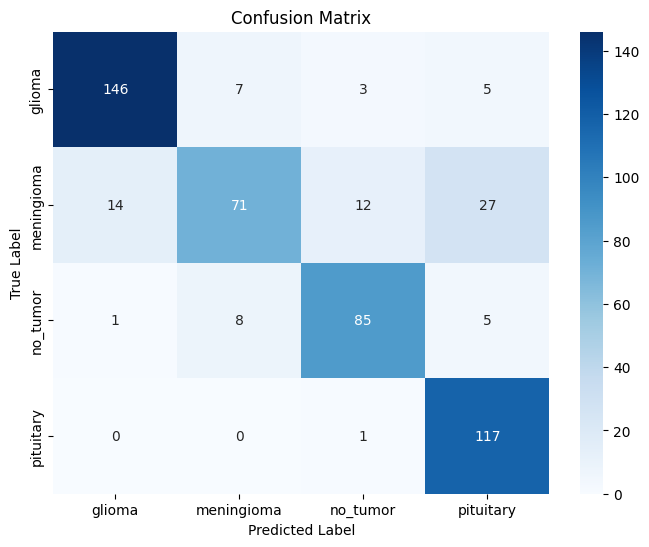

In [ ]:
# Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


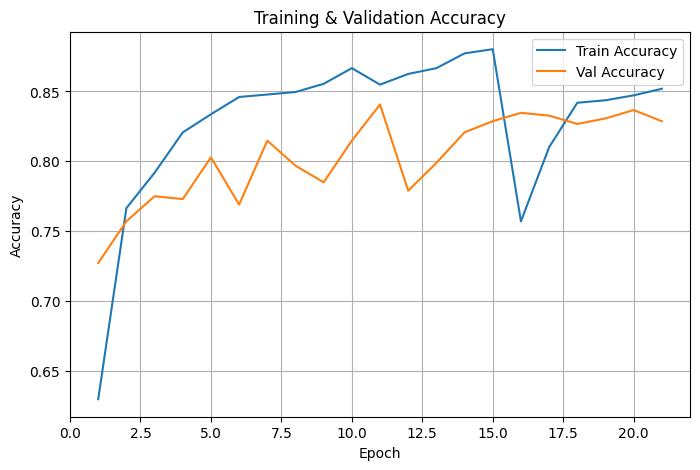

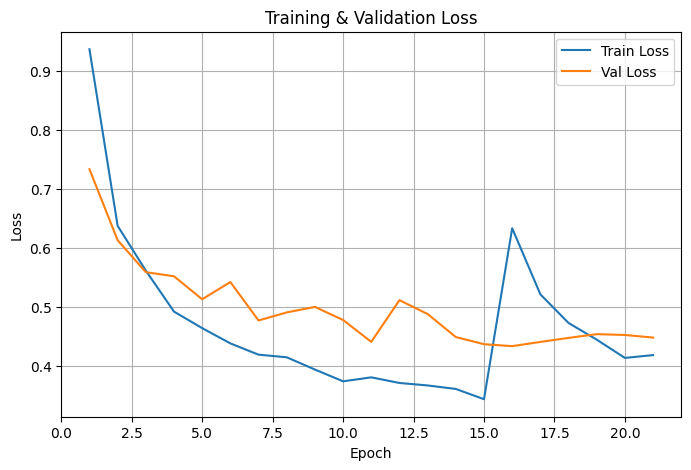

In [ ]:
# Training History Plots — Accuracy and Loss
# Merge history
acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']

loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

epochs = range(1, len(acc) + 1)

# ACCURACY
plt.figure(figsize=(8,5))
plt.plot(epochs, acc, label="Train Accuracy")
plt.plot(epochs, val_acc, label="Val Accuracy")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# lOSS
plt.figure(figsize=(8,5))
plt.plot(epochs, loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# 8. Model Comparision
# Compare Validation Accuracy
cnn_val_acc = max(history.history['val_accuracy'])
eff_val_acc = max(history1.history['val_accuracy'] + history2.history['val_accuracy'])

print("Custom CNN best Val Accuracy :", cnn_val_acc)
print("EfficientNetB0 best Val Accuracy :", eff_val_acc)


Custom CNN best Val Accuracy : 0.912350594997406
EfficientNetB0 best Val Accuracy : 0.8406374454498291


In [ ]:
cnn_y_true = []
cnn_y_pred = []

for images, labels in ds_val:
    preds = model.predict(images)
    cnn_y_pred.extend(np.argmax(preds, axis=1))
    cnn_y_true.extend(np.argmax(labels.numpy(), axis=1))

# Compare F1-score
from sklearn.metrics import f1_score

f1_eff = f1_score(y_true, y_pred, average='weighted')
print("EfficientNet Weighted F1-score:", f1_eff)

# Assuming cnn_y_true, cnn_y_pred collected similarly
f1_cnn = f1_score(cnn_y_true, cnn_y_pred, average='weighted')
print("Custom CNN Weighted F1-score:", f1_cnn)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
EfficientNet Weighted F1-score: 0.8277137946812191
Custom CNN Weighted F1-score: 0.10936253566188082


In [ ]:
# Compare Model Size (Efficiency)
cnn_params = model.count_params()
eff_params = eff_model.count_params()

print("Custom CNN parameters :", cnn_params)
print("EfficientNetB0 parameters :", eff_params)


Custom CNN parameters : 1803844
EfficientNetB0 parameters : 4054695


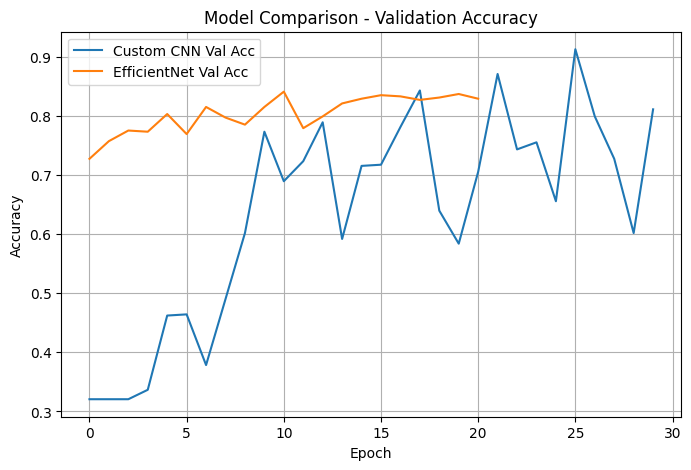

In [ ]:
# Plot Accuracy Comparison
plt.figure(figsize=(8,5))
plt.plot(history.history['val_accuracy'], label='Custom CNN Val Acc')
plt.plot(history1.history['val_accuracy'] + history2.history['val_accuracy'],
         label='EfficientNet Val Acc')
plt.title("Model Comparison - Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

eff_y_true = []
eff_y_pred = []

for images, labels in ds_val:
    preds = eff_model.predict(images)
    eff_y_pred.extend(np.argmax(preds, axis=1))
    eff_y_true.extend(np.argmax(labels.numpy(), axis=1))

# Create confusion matrix
eff_cm = confusion_matrix(eff_y_true, eff_y_pred)

print("Confusion Matrix for EfficientNet:")
print(eff_cm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Confusion Matrix for EfficientNet:
[[146   7   3   5]
 [ 14  71  12  27]
 [  1   8  85   5]
 [  0   0   1 117]]


In [ ]:
import os

save_dir = "/content/drive/MyDrive/Brain Tumor/models"
os.makedirs(save_dir, exist_ok=True)
print("Models folder ready:", save_dir)

model.save("/content/drive/MyDrive/Brain Tumor/models/custom_cnn_model.keras")
print("CNN model saved.")
eff_model.save("/content/drive/MyDrive/Brain Tumor/models/efficientnet_finetuned.keras")
print("EfficientNet model saved.")

Models folder ready: /content/drive/MyDrive/Brain Tumor/models
CNN model saved.
EfficientNet model saved.
